In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import NMF

from utilities import one_hot

BREAST_PATH = '../data/breast.csv'
HR_PATH = '../data/human_resources.csv'
SONAR_PATH = '../data/sonar.csv'
SPAM_PATH = '../data/spam.csv'
SMOKING_PATH = '../data/smoking.csv'

In [252]:
"""
Spam base dataset
"""
def init_spam():
    dataset_name = "spam"
    spam_features = ['word_freq_make','word_freq_address','word_freq_all','word_freq_3d','word_freq_our','word_freq_over','word_freq_remove','word_freq_internet','word_freq_order','word_freq_mail','word_freq_receive','word_freq_will','word_freq_people','word_freq_report','word_freq_addresses','word_freq_free','word_freq_business','word_freq_email','word_freq_you','word_freq_credit','word_freq_your','word_freq_font','word_freq_000','word_freq_money','word_freq_hp','word_freq_hpl','word_freq_george','word_freq_650','word_freq_lab','word_freq_labs','word_freq_telnet','word_freq_857','word_freq_data','word_freq_415','word_freq_85','word_freq_technology','word_freq_1999','word_freq_parts','word_freq_pm','word_freq_direct','word_freq_cs','word_freq_meeting','word_freq_original','word_freq_project','word_freq_re','word_freq_edu','word_freq_table','word_freq_conference','char_freq_;','char_freq_(','char_freq_[','char_freq_!','char_freq_$','char_freq_#','capital_run_length_average','capital_run_length_longest','capital_run_length_total','label']
    spam_dataset = pd.read_csv(f"../raw_data/{dataset_name}.csv", header=None)
    spam_dataset.columns=spam_features
    spam_dataset.to_csv(SPAM_PATH, index = False)

"""
Sonar dataset
"""
def init_sonar():
    dataset_name = "sonar"
    sonar_dataset = pd.read_csv(f"../raw_data/{dataset_name}.csv", names = range(0,61))
    sonar_dataset.rename(columns={60:'label'}, inplace=True)
    sonar_dataset['label'].replace(0, 'R',inplace=True)
    sonar_dataset['label'].replace(1, 'M',inplace=True)
    sonar_dataset.to_csv(SONAR_PATH, index = False)

"""
Smoking dataset
"""
def init_smoking():
    smoking_dataset = pd.read_csv(f"../raw_data/smoking.csv")
    smoking_dataset = smoking_dataset.drop(['ID'], axis=1)
    smoking_dataset_label = smoking_dataset.pop('smoking')
    smoking_dataset = one_hot(smoking_dataset, 'gender')
    smoking_dataset = one_hot(smoking_dataset, 'oral')
    smoking_dataset.rename(columns={'Y':'oral'}, inplace=True)
    smoking_dataset = one_hot(smoking_dataset, 'tartar')
    smoking_dataset.rename(columns={'Y':'tartar'}, inplace=True)
    smoking_dataset.rename(columns={'N':'no_tartar'}, inplace=True)
    smoking_dataset.insert(len(smoking_dataset.columns), 'smoking', smoking_dataset_label)
    smoking_dataset.to_csv(SMOKING_PATH, index = False)
    

"""
Human resources dataset
"""
def init_hr():
    dataset_name = "human_resources"
    hr_dataset = pd.read_csv(f"../raw_data/{dataset_name}.csv")
    hr_labels = hr_dataset.pop('left')
    hr_dataset.rename(columns={'sales':'department'}, inplace=True)
    hr_dataset = one_hot(hr_dataset, 'salary')
    hr_dataset = one_hot(hr_dataset, 'department')
    hr_dataset.insert(len(hr_dataset.columns), 'left', hr_labels)
    hr_dataset.to_csv(HR_PATH, index = False)
    
"""
Breast dataset
"""
def init_breast():
       breast_dataset = pd.DataFrame(pd.read_csv(f"../raw_data/breast.csv"))
       breast_labels = breast_dataset.pop('diagnosis')
       breast_dataset.drop(columns=(['id', 'Unnamed: 32']), inplace=True)
       breast_dataset.insert(len(breast_dataset.columns), 'diagnosis', breast_labels)
       breast_dataset.to_csv(BREAST_PATH, index = False)


In [253]:
init_hr()
init_smoking()
init_breast()
init_spam()
init_sonar()

In [254]:
def standardize_dataset(path):
    data = pd.read_csv(path)
    features = list(data.columns[:-1])
    x = data.loc[:, features].values
    x = StandardScaler().fit_transform(x)
    return x

def pca_transform(standardized_data, n):
    pca = PCA(n_components=n)
    principalComponents = pca.fit_transform(standardized_data)
    print(f'EXPLAINED VARIANCE RATIO:\t{np.around(pca.explained_variance_ratio_, decimals=3)}\nINFORMATION LOSS:\t\t{1-sum(pca.explained_variance_ratio_):.3}\n')
    return principalComponents

def kernel_pca_transform(standardized_data, n):
    kernel_pca = KernelPCA(n_components=2)
    principalComponents = kernel_pca.fit_transform(standardized_data)
    print(f'EXPLAINED VARIANCE RATIO:\t:(\nINFORMATION LOSS:\t\t:(\n')
    return principalComponents

def sparse_pca_transform(standardized_data, n):
    sparse_pca = SparsePCA(n_components=n)
    principalComponents = sparse_pca.fit_transform(standardized_data)
    print(f'EXPLAINED VARIANCE RATIO:\t:(\nINFORMATION LOSS:\t\t:(\n')
    return principalComponents

PCA----------------------../data/human_resources.csv
EXPLAINED VARIANCE RATIO:	[0.094 0.091]
INFORMATION LOSS:		0.814

Kernel-PCA---------------../data/human_resources.csv
EXPLAINED VARIANCE RATIO:	:(
INFORMATION LOSS:		:(

Sparse-PCA---------------../data/human_resources.csv
EXPLAINED VARIANCE RATIO:	:(
INFORMATION LOSS:		:(

PCA----------------------../data/smoking.csv
EXPLAINED VARIANCE RATIO:	[0.203 0.092]
INFORMATION LOSS:		0.704

Sparse-PCA---------------../data/smoking.csv
EXPLAINED VARIANCE RATIO:	:(
INFORMATION LOSS:		:(

PCA----------------------../data/breast.csv
EXPLAINED VARIANCE RATIO:	[0.443 0.19 ]
INFORMATION LOSS:		0.368

Kernel-PCA---------------../data/breast.csv
EXPLAINED VARIANCE RATIO:	:(
INFORMATION LOSS:		:(

Sparse-PCA---------------../data/breast.csv
EXPLAINED VARIANCE RATIO:	:(
INFORMATION LOSS:		:(

PCA----------------------../data/spam.csv
EXPLAINED VARIANCE RATIO:	[0.115 0.058]
INFORMATION LOSS:		0.827

Kernel-PCA---------------../data/spam.csv
EXPLAINED V

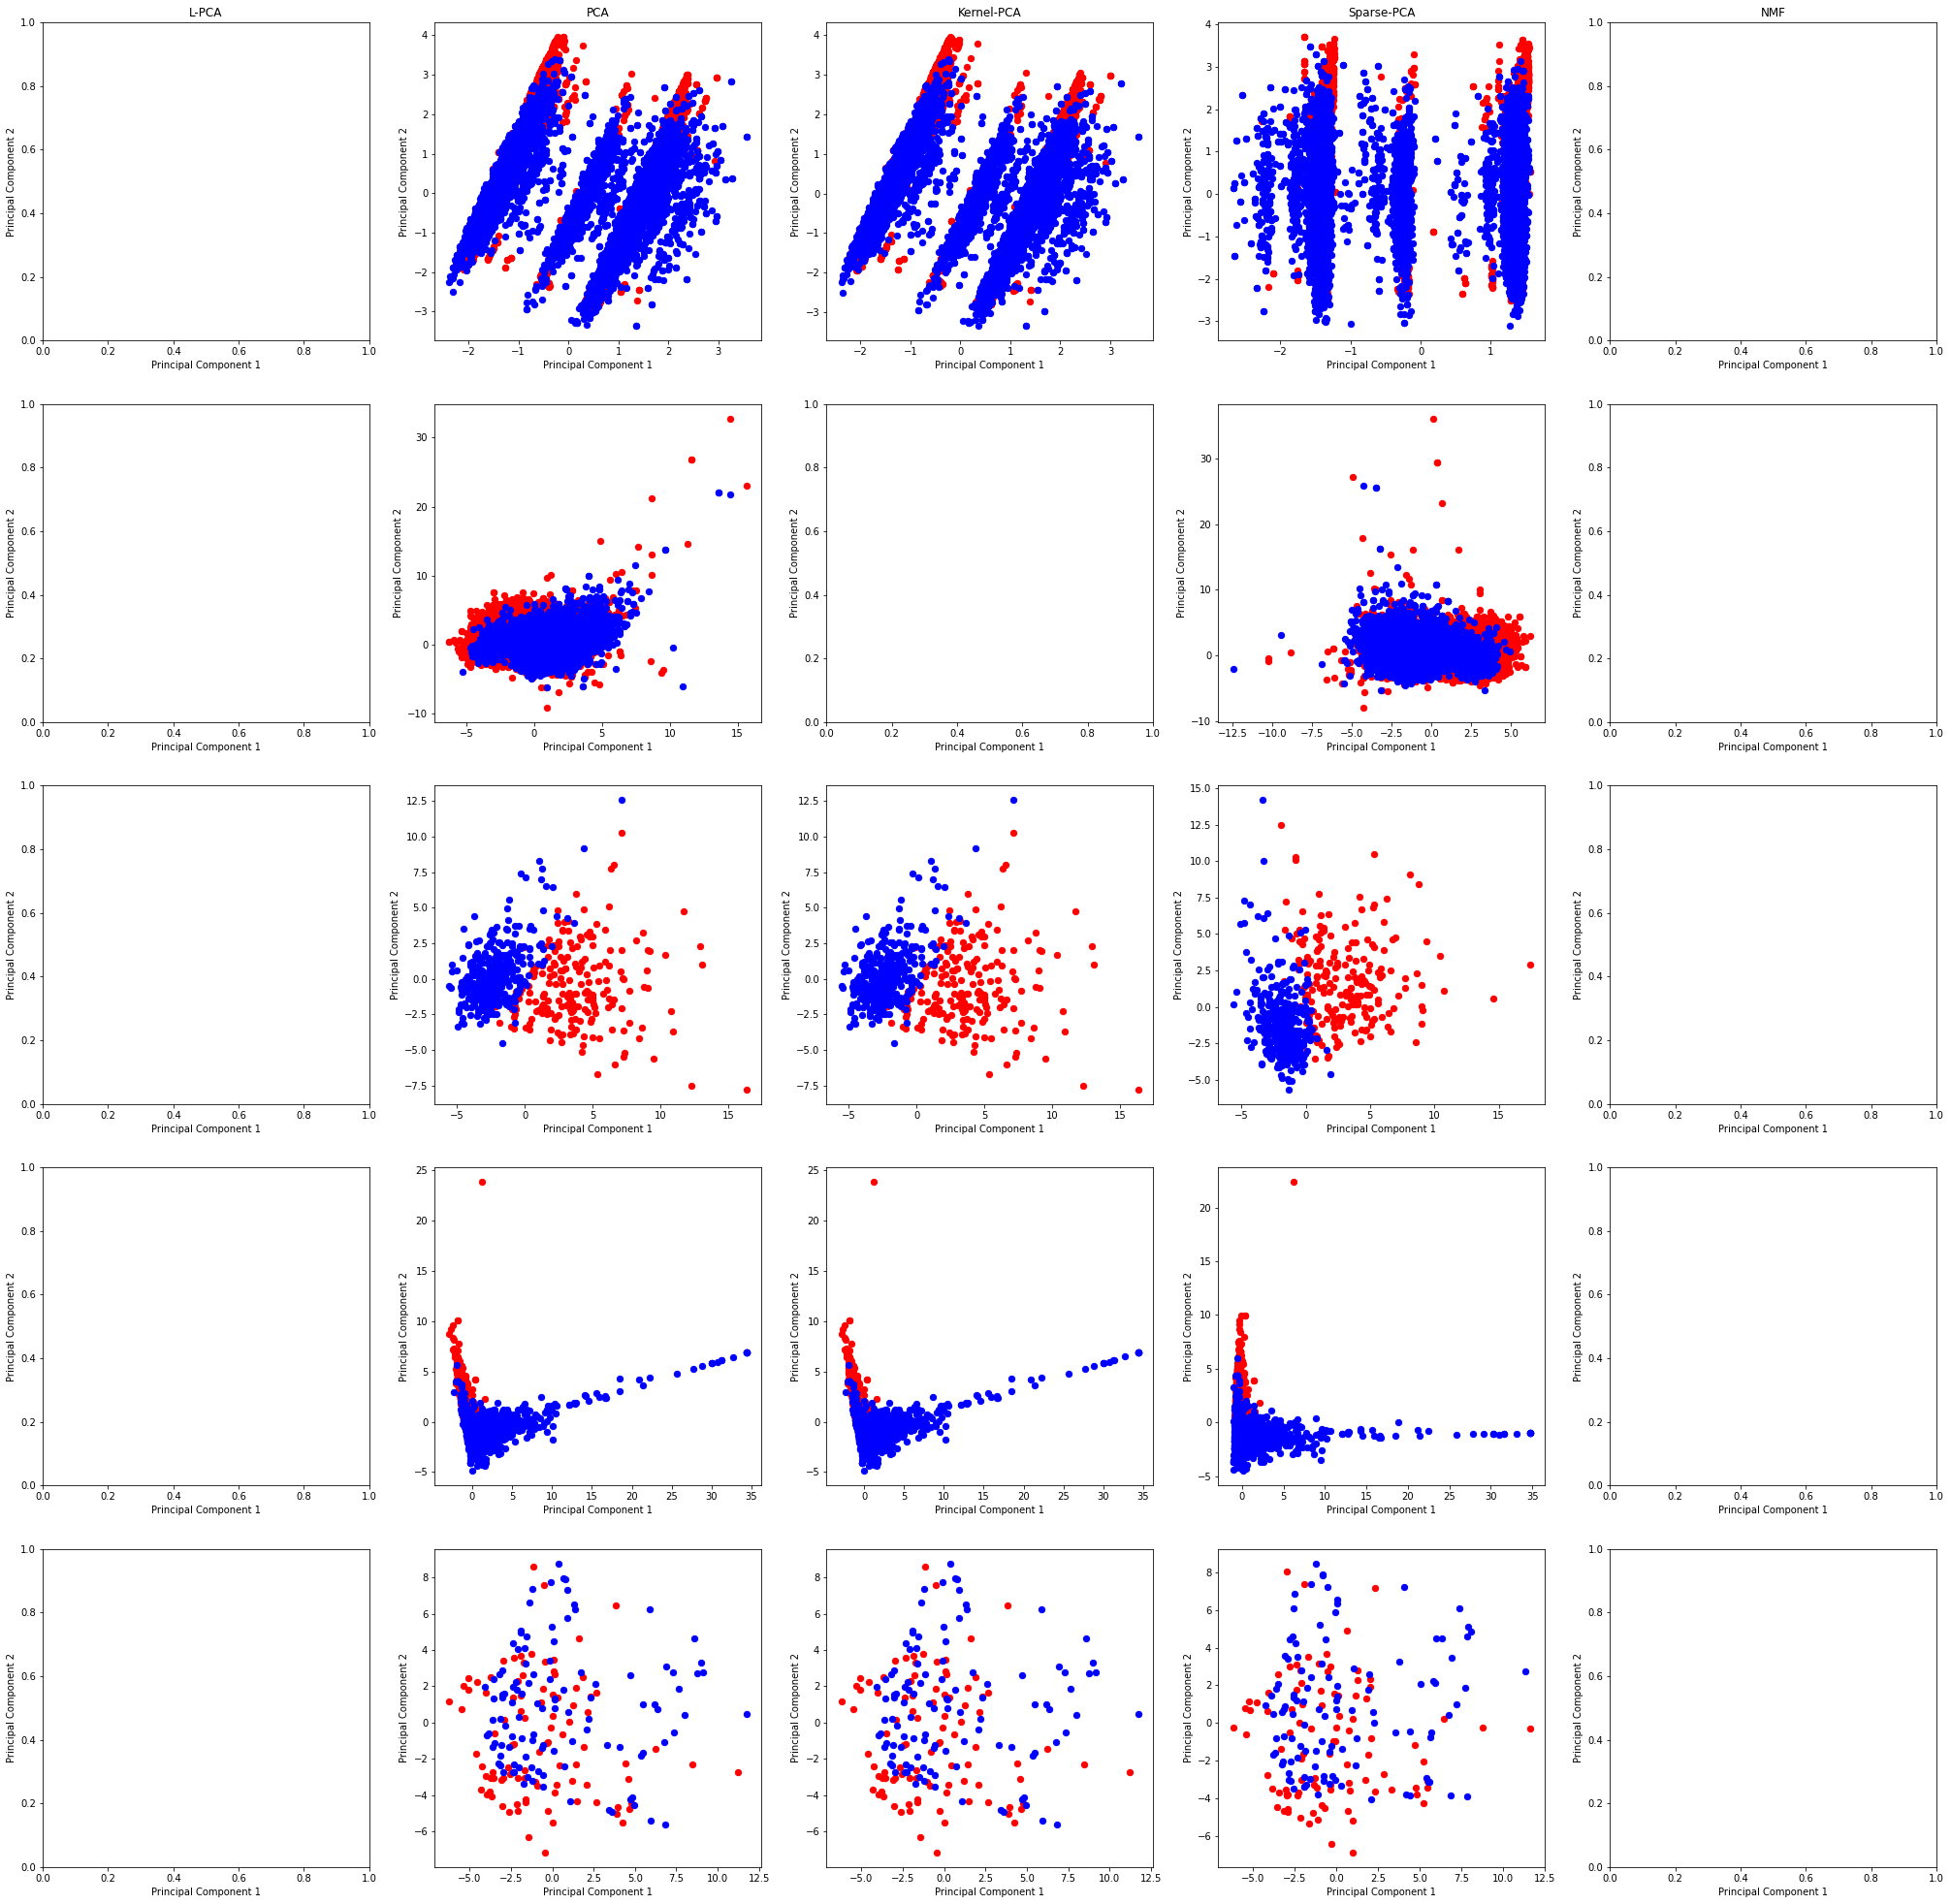

In [257]:
def draw_plots():
    dataset_paths = [HR_PATH, SMOKING_PATH, BREAST_PATH, SPAM_PATH, SONAR_PATH]
    methods = ['L-PCA', 'PCA', 'Kernel-PCA', 'Sparse-PCA', 'NMF']
    fig, axs = plt.subplots(len(dataset_paths), len(methods), figsize=(35,35))

    for row, path in enumerate(dataset_paths):
        dataset = pd.read_csv(path)
        targets = dataset[dataset.columns[-1]].unique()
        colors = ['r', 'b']
        for column, method in enumerate(methods):
            if row == 0:
                axs[row,column].set_title(method)

            if method=='PCA':
                print(f"PCA----------------------{path}")
                pca_df = pd.DataFrame(data = pca_transform(standardize_dataset(path), 2), columns = ['principal component 1', 'principal component 2'])
            elif method=='Kernel-PCA' and row !=1:
                print(f"Kernel-PCA---------------{path}")
                kernel_pca_df = pd.DataFrame(data = kernel_pca_transform(standardize_dataset(path), 2), columns = ['principal component 1', 'principal component 2'])
            elif method=='Sparse-PCA':
                print(f"Sparse-PCA---------------{path}")
                sparse_pca_df = pd.DataFrame(data = sparse_pca_transform(standardize_dataset(path), 2), columns = ['principal component 1', 'principal component 2'])

            for (target, color) in zip(targets,colors):
                indicesToKeep = pd.read_csv(path)[dataset.columns[-1]] == target

                if method=='PCA':
                    axs[row, column].scatter(pca_df.loc[indicesToKeep, 'principal component 1']
                    , pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 40)
                elif method=='Kernel-PCA' and row !=1:
                    axs[row, column].scatter(kernel_pca_df.loc[indicesToKeep, 'principal component 1']
                    , kernel_pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 40)
                elif method=='Sparse-PCA':
                    axs[row, column].scatter(sparse_pca_df.loc[indicesToKeep, 'principal component 1']
                    , sparse_pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 40)




    for ax in axs.flat:
        ax.set(xlabel='Principal Component 1', ylabel='Principal Component 2')

draw_plots()